In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [2]:
df = pd.read_csv('KwhConsumptionBlower78_1.csv')
df = df[['TxnDate', 'TxnTime', 'Consumption']]
df.rename(columns={'TxnDate': 'date', 'TxnTime': 'time', 'Consumption': 'consumption'}, inplace=True)
df

,date,time,consumption
0,01 Jan 2022,16:55:52,1.010
1,01 Jan 2022,21:45:29,0.908
2,01 Jan 2022,12:24:52,0.926
3,01 Jan 2022,04:07:36,0.928
4,01 Jan 2022,06:52:25,0.916
...,...,...,...
1223,20 Jan 2022,21:43:55,5.128
1224,20 Jan 2022,09:43:03,5.924
1225,20 Jan 2022,03:06:05,4.664
1226,20 Jan 2022,06:16:38,3.474


In [3]:
df.reset_index(inplace=True)
df

,index,date,time,consumption
0,0,01 Jan 2022,16:55:52,1.010
1,1,01 Jan 2022,21:45:29,0.908
2,2,01 Jan 2022,12:24:52,0.926
3,3,01 Jan 2022,04:07:36,0.928
4,4,01 Jan 2022,06:52:25,0.916
...,...,...,...,...
1223,1223,20 Jan 2022,21:43:55,5.128
1224,1224,20 Jan 2022,09:43:03,5.924
1225,1225,20 Jan 2022,03:06:05,4.664
1226,1226,20 Jan 2022,06:16:38,3.474


In [4]:
df.isnull().sum()

index          0
date           0
time           0
consumption    0
dtype: int64

In [5]:
df['hour_start'] = df['time'].apply(lambda x: int(x[:2]))
df['hour_end'] = df['hour_start'].apply(lambda x: x + 1)
df['hour_range'] = df.apply(lambda row: f'{row["hour_start"]}-{row["hour_end"]}', axis=1)
df.drop(columns=['time', 'index'], inplace=True)

df

,date,consumption,hour_start,hour_end,hour_range
0,01 Jan 2022,1.010,16,17,16-17
1,01 Jan 2022,0.908,21,22,21-22
2,01 Jan 2022,0.926,12,13,12-13
3,01 Jan 2022,0.928,4,5,4-5
4,01 Jan 2022,0.916,6,7,6-7
...,...,...,...,...,...
1223,20 Jan 2022,5.128,21,22,21-22
1224,20 Jan 2022,5.924,9,10,9-10
1225,20 Jan 2022,4.664,3,4,3-4
1226,20 Jan 2022,3.474,6,7,6-7


In [6]:
# Grouping the data into time ranges, and get the mean if there are more data in that time range
df = df.groupby(by=['date', 'hour_range']).mean().sort_values(by=['date', 'hour_start', 'hour_end']).reset_index()
df['weekday'] = df['date'].apply(lambda x: pd.to_datetime(x).day_name())
df

,date,hour_range,consumption,hour_start,hour_end,weekday
0,01 Jan 2022,0-1,0.967000,0.0,1.0,Saturday
1,01 Jan 2022,1-2,1.377000,1.0,2.0,Saturday
2,01 Jan 2022,2-3,1.485000,2.0,3.0,Saturday
3,01 Jan 2022,3-4,0.929333,3.0,4.0,Saturday
4,01 Jan 2022,4-5,0.922667,4.0,5.0,Saturday
...,...,...,...,...,...,...
475,20 Jan 2022,19-20,6.758000,19.0,20.0,Thursday
476,20 Jan 2022,20-21,6.718000,20.0,21.0,Thursday
477,20 Jan 2022,21-22,5.202667,21.0,22.0,Thursday
478,20 Jan 2022,22-23,6.030667,22.0,23.0,Thursday


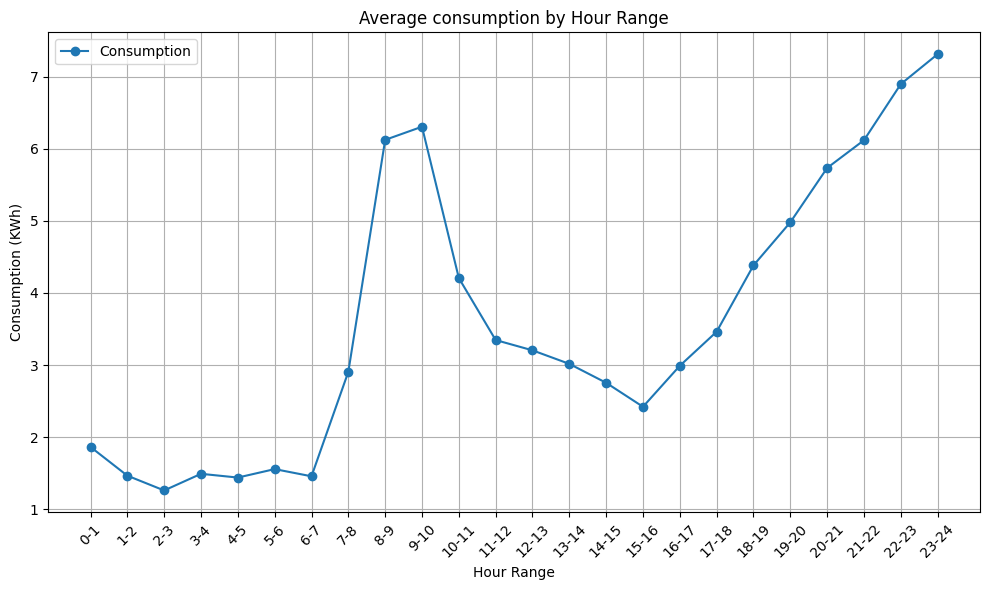

In [7]:
df_hourly_avg = df.groupby(by='hour_range')[['consumption', 'hour_start', 'hour_end']].mean().sort_values(by=['hour_start', 'hour_end'])['consumption']
plt.figure(figsize=(10, 6))
plt.plot(df_hourly_avg.index, df_hourly_avg, marker='o', linestyle='-', label='Consumption')
plt.xticks(rotation=45)
plt.xlabel('Hour Range')
plt.ylabel('Consumption (KWh)')
plt.title('Average consumption by Hour Range')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Check if all dates have all the hour ranges
ref_df = pd.DataFrame(df_hourly_avg).reset_index()
original_dates = df['date'].unique()
dates = pd.date_range(start=original_dates.min(), end=original_dates.max()).strftime('%d %b %Y')
hours = ref_df['hour_range']
full_grid = pd.MultiIndex.from_product([dates, hours], names=["date", "hour_range"]).to_frame(index=False)
merged = pd.merge(full_grid, df, on=["date", "hour_range"], how="left")
merged.isnull().sum() # No nulls

date           0
hour_range     0
consumption    0
hour_start     0
hour_end       0
weekday        0
dtype: int64

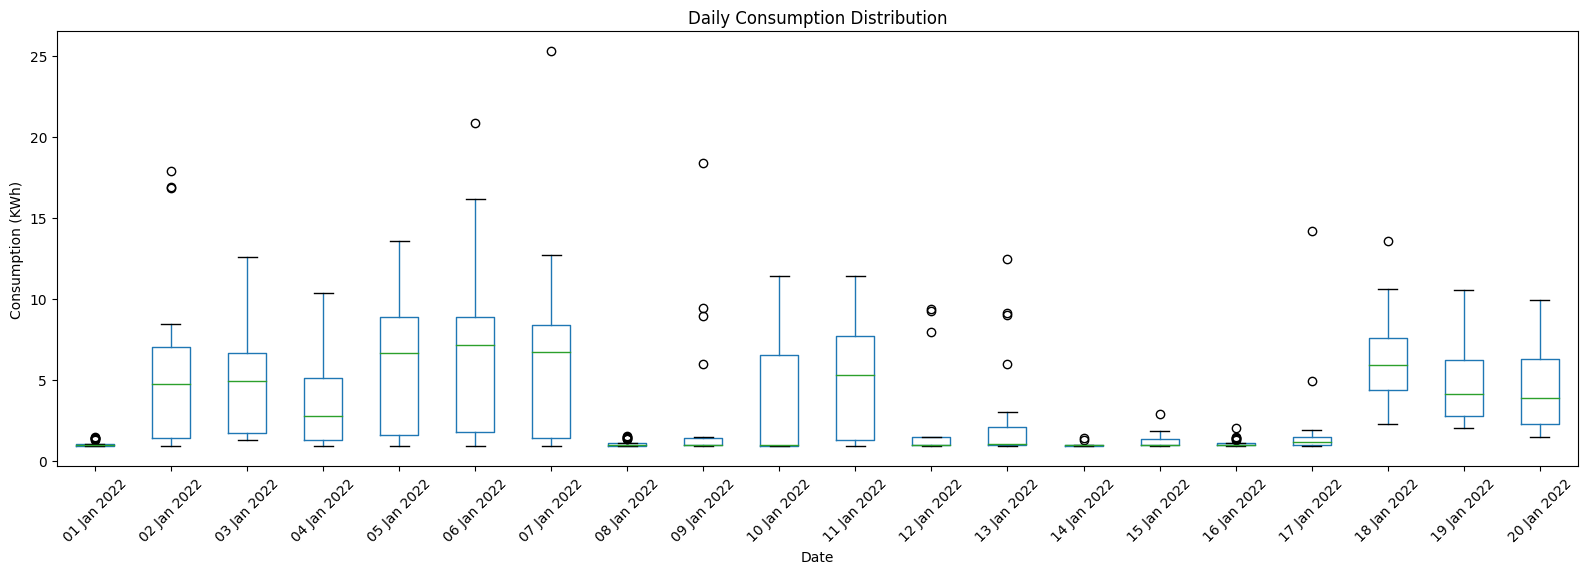

In [9]:
df.boxplot(column='consumption', by='date',grid=False, rot=45, figsize=(16, 6))
plt.title("Daily Consumption Distribution")
plt.suptitle("")
plt.xlabel("Date")
plt.ylabel("Consumption (KWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

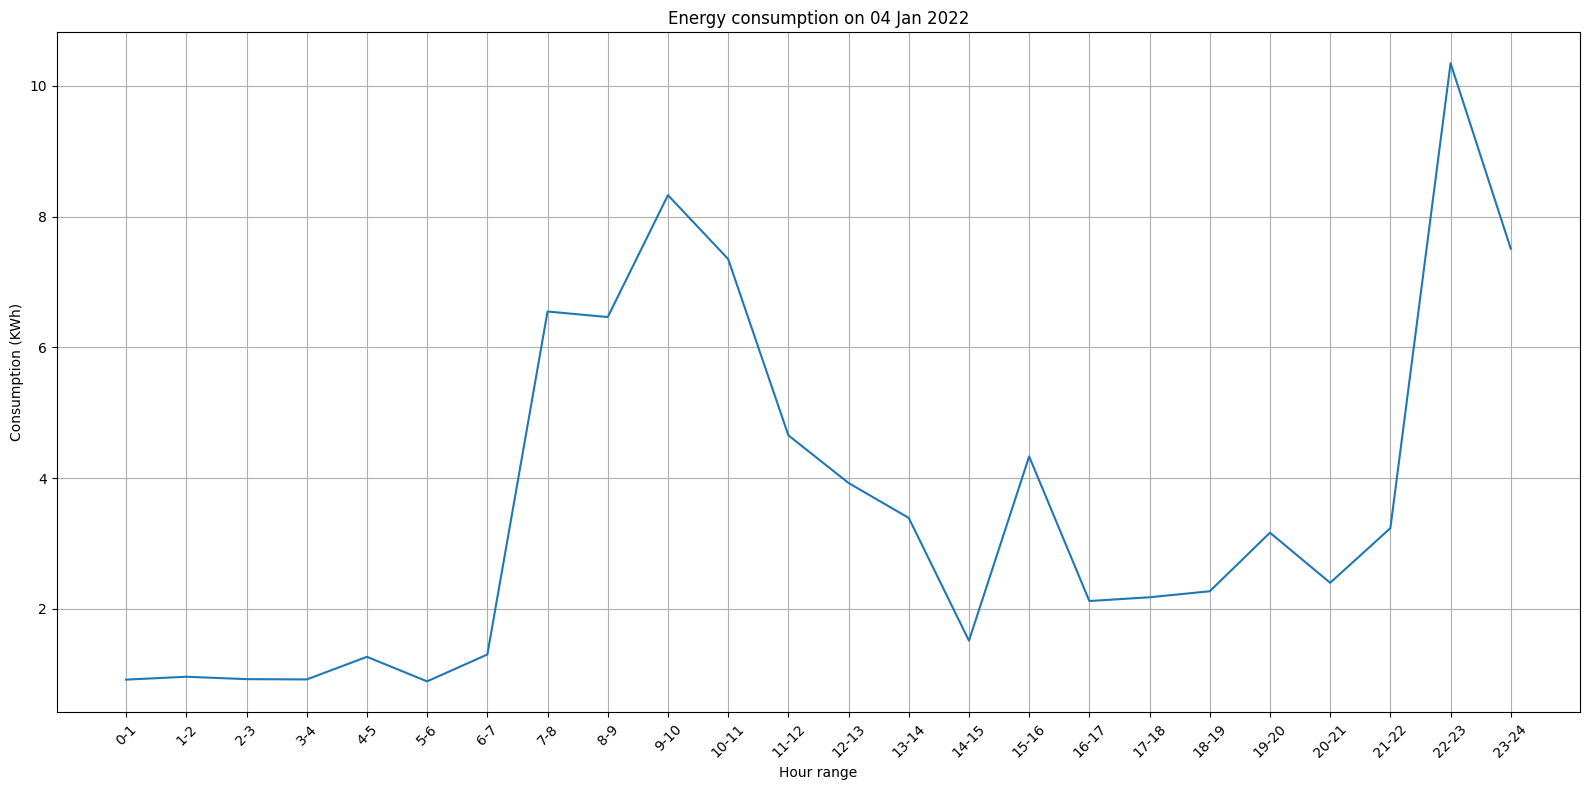

In [10]:
date = original_dates[3]
plt.figure(figsize=(16, 8))
temp_df = df.groupby('date').get_group(date).reset_index()[['hour_range', 'consumption']]
plt.plot(temp_df['hour_range'], temp_df['consumption'])
plt.title(f'Energy consumption on {date}')
plt.xlabel("Hour range")
plt.ylabel("Consumption (KWh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

In [11]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_df = df.groupby('weekday')['consumption'].mean()
weekday_df.index = pd.CategoricalIndex(weekday_df.index, categories=weekday_order, ordered=True)
weekday_df.sort_index(inplace=True)
weekday_df

weekday
Monday       3.489042
Tuesday      4.901824
Wednesday    4.360352
Thursday     4.598081
Friday       3.704687
Saturday     1.114954
Sunday       3.146970
Name: consumption, dtype: float64

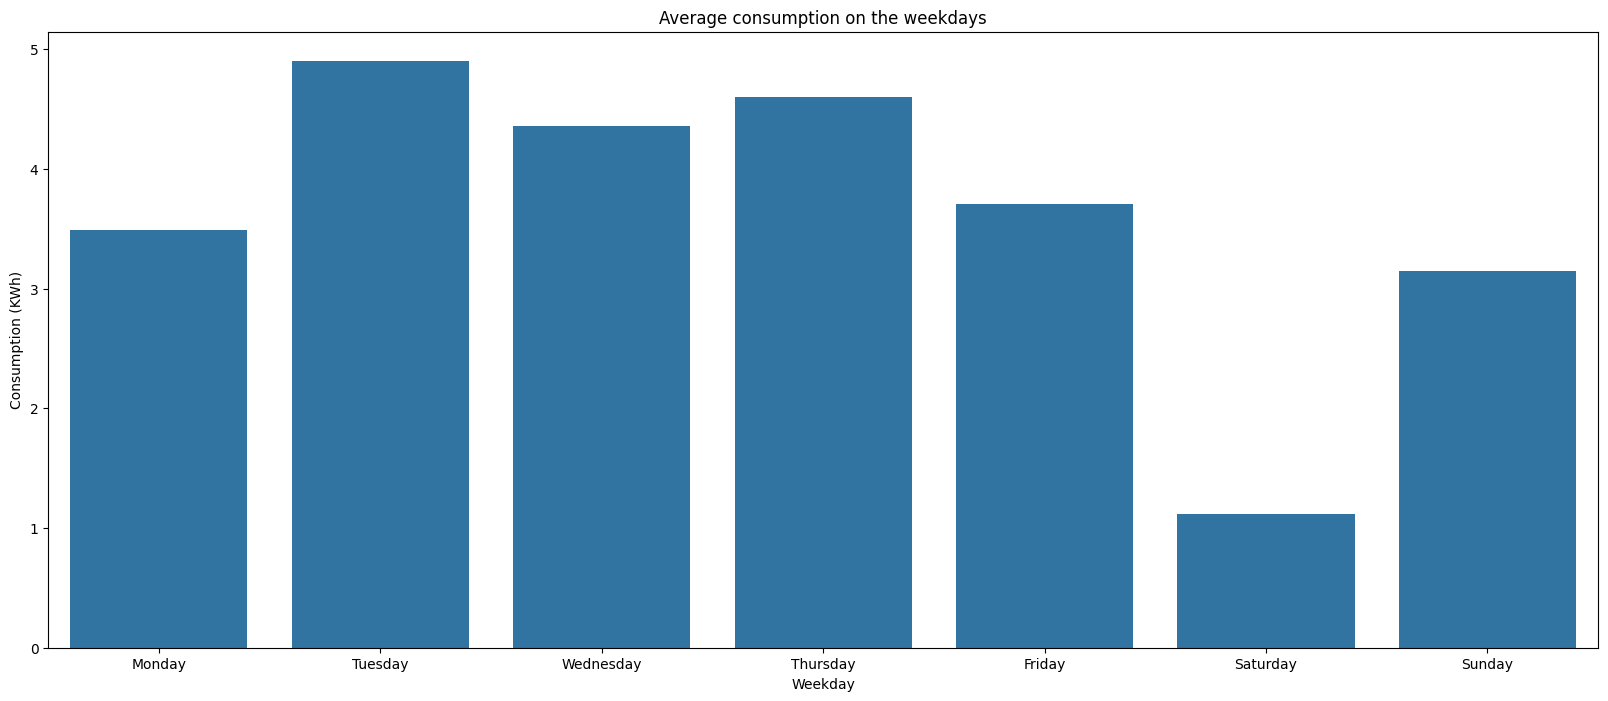

In [12]:
plt.figure(figsize=(20,8))
sns.barplot(weekday_df)
plt.xlabel('Weekday')
plt.ylabel('Consumption (KWh)')
plt.title('Average consumption on the weekdays')
plt.show()

In [13]:
timeseries = df['consumption'].to_numpy()
timeseries[:10]

array([0.967     , 1.377     , 1.485     , 0.92933333, 0.92266667,
       0.976     , 0.936     , 0.97      , 1.276     , 1.399     ])

In [14]:
train_size = int(len(timeseries) * 0.6)
valid_size = int(len(timeseries) * 0.2)
test_size = len(timeseries) - train_size - valid_size

train, valid, test = timeseries[:train_size], timeseries[train_size:train_size+valid_size],timeseries[train_size+valid_size:]

In [15]:
train.shape, valid.shape, test.shape

((288,), (96,), (96,))

In [16]:
def create_dataset(dataset: np.ndarray, window: int):
    X = np.zeros(shape=(dataset.shape[0]-window, window, 1))
    y = np.zeros_like(X)
    for i in range(dataset.shape[0]-window):
        X[i, :, 0] =  dataset[i:i+window]
        y[i, :, 0] = dataset[i+1:i+1+window]
    return torch.tensor(X, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [17]:
window = 5
X_train, y_train = create_dataset(train, window)
X_val, y_val = create_dataset(valid, window)
X_test, y_test = create_dataset(test, window)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([283, 5, 1]),
 torch.Size([91, 5, 1]),
 torch.Size([91, 5, 1]),
 torch.Size([283, 5, 1]),
 torch.Size([91, 5, 1]),
 torch.Size([91, 5, 1]))

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, in_features: int, hidden_features: int, out_features: int, num_layers: int, dropout: float):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_features, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.linear = nn.Linear(hidden_features, out_features)

    def forward(self, x: torch.Tensor):
        out, _ = self.lstm(x) # (seq_length, hidden_features)
        out = self.linear(out) # (seq_length, out_features)
        return out


In [19]:
in_features = X_train.shape[-1]
hidden_features = 64
out_features = 1

model = LSTMModel(in_features, hidden_features, out_features, num_layers=2, dropout=0.2)
model(X_train).shape

torch.Size([283, 5, 1])

In [20]:
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

In [21]:
loss_fn = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100
losses = []
val_losses = []
patience = 10
patience_counter = 0
best_loss = np.inf
best_state_dict = None
for epoch in range(num_epochs):
    epoch_loss = []
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    epoch_loss_mean = np.mean(epoch_loss)
    losses.append(epoch_loss_mean)
    model.eval()
    with torch.inference_mode():
        pred = model(X_val)
        loss = loss_fn(pred, y_val).item()
        val_losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            best_state_dict = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stop')
                break        
    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss_mean:.3f} | Val Loss: {loss:.3f}')
model.load_state_dict(best_state_dict)

Epoch: 1 | Loss: 26.505 | Val Loss: 4.898
Epoch: 2 | Loss: 16.520 | Val Loss: 4.764
Epoch: 3 | Loss: 12.527 | Val Loss: 2.211
Epoch: 4 | Loss: 8.757 | Val Loss: 1.629
Epoch: 5 | Loss: 7.723 | Val Loss: 1.712
Epoch: 6 | Loss: 7.645 | Val Loss: 1.338
Epoch: 7 | Loss: 7.477 | Val Loss: 1.544
Epoch: 8 | Loss: 6.696 | Val Loss: 1.267
Epoch: 9 | Loss: 6.771 | Val Loss: 1.448
Epoch: 10 | Loss: 6.653 | Val Loss: 1.442
Epoch: 11 | Loss: 6.542 | Val Loss: 1.292
Epoch: 12 | Loss: 6.581 | Val Loss: 1.427
Epoch: 13 | Loss: 6.536 | Val Loss: 1.335
Epoch: 14 | Loss: 6.494 | Val Loss: 1.570
Epoch: 15 | Loss: 6.475 | Val Loss: 1.446
Epoch: 16 | Loss: 6.414 | Val Loss: 1.293
Epoch: 17 | Loss: 6.423 | Val Loss: 1.485
Early stop


<All keys matched successfully>

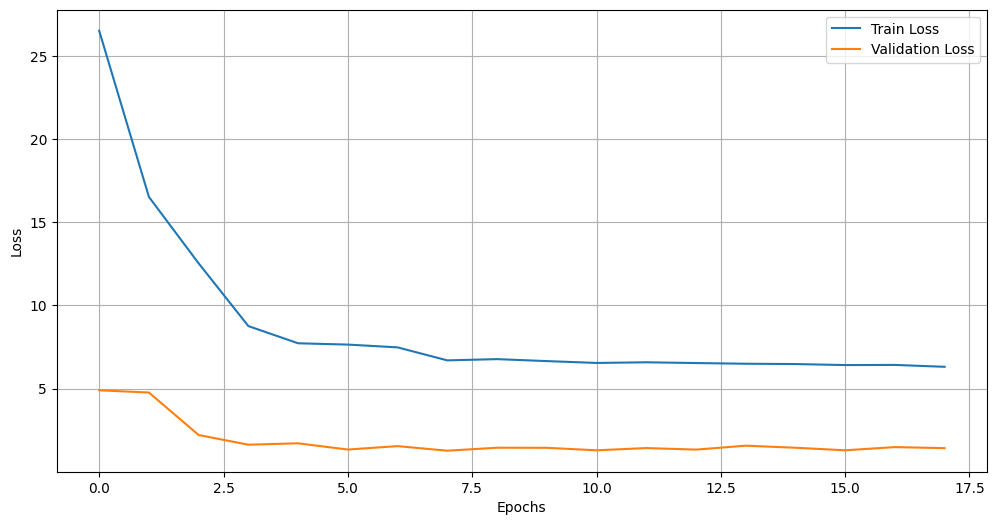

In [22]:
plt.figure(figsize=(12,6))
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

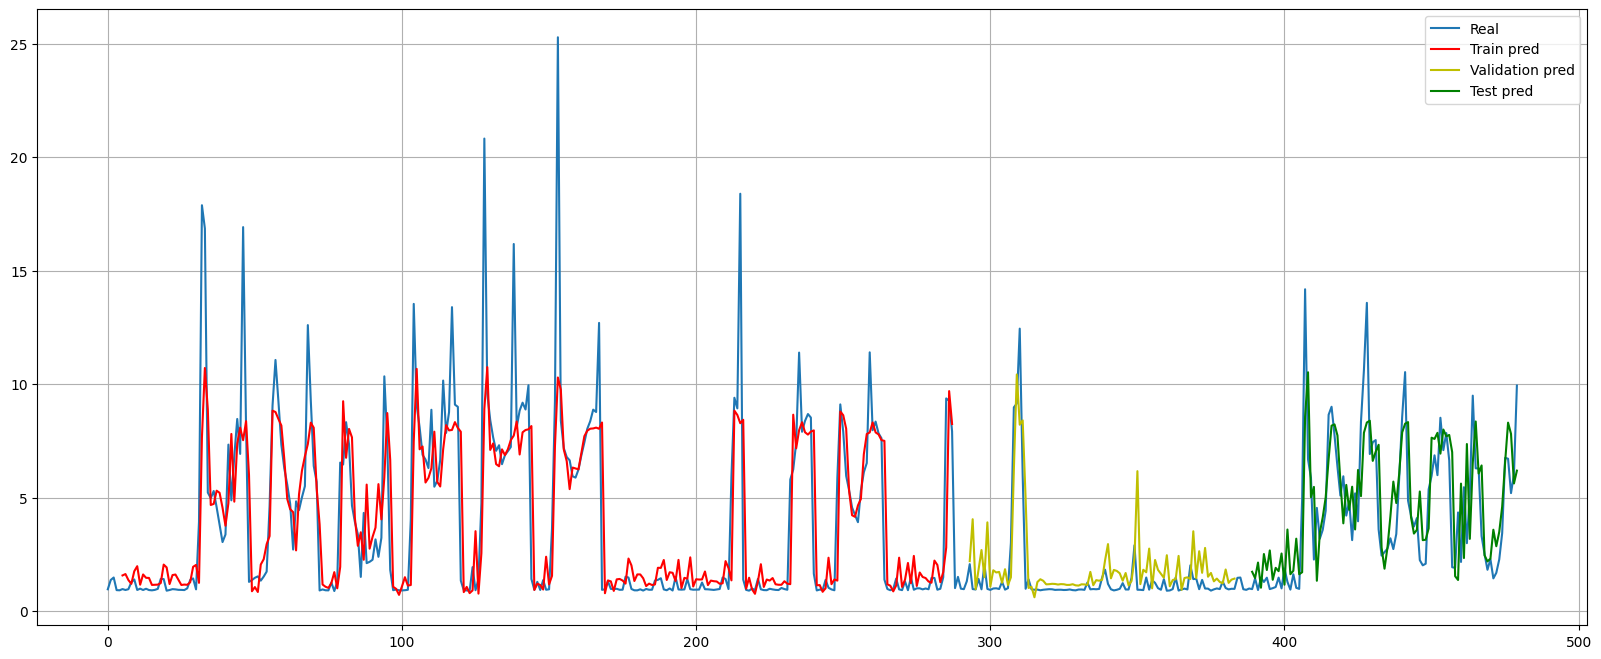

In [25]:
model.eval()
with torch.inference_mode():
    train_plot = (np.ones(shape=(timeseries.shape[0], 1)) * np.nan)[:,0]
    valid_plot = (np.ones_like(train_plot) * np.nan)
    test_plot = (np.ones_like(train_plot) * np.nan)
    train_plot[window:train_size] = model(X_train)[:, -1, -1]
    valid_plot[train_size+window:train_size+valid_size] = model(X_val)[:, -1, -1]
    test_plot[train_size+valid_size+window:len(timeseries)] = model(X_test)[:, -1, -1]
plt.figure(figsize=(20,8))
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(valid_plot, c='y')
plt.plot(test_plot, c='g')
plt.legend(['Real','Train pred', 'Validation pred', 'Test pred'])
plt.grid()
plt.show()

In [349]:
def positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe # (seq_length, d_model)

In [301]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, out_features: int, seq_length: int, num_heads: int):
        super(MultiHeadAttention, self).__init__()
        self.d_k = d_model
        self.num_heads = num_heads
        self.seq_length = seq_length
        self.Q = nn.Linear(d_model, self.d_k * num_heads)
        self.K = nn.Linear(d_model, self.d_k * num_heads)
        self.V = nn.Linear(d_model, self.d_k * num_heads)
        self.linear = nn.Linear(self.d_k, out_features)

    def forward(self, x: torch.Tensor, masked: bool = False):
        query = self.Q(x)
        key = self.K(x)
        value = self.V(x)
        query = query.view(-1, self.num_heads, self.seq_length, self.d_k) # (batch_size, num_heads, seq_length, d_k)
        key = key.view(-1, self.num_heads, self.seq_length, self.d_k) # (batch_size, num_heads, seq_length, d_k)
        value = value.view(-1, self.num_heads, self.seq_length, self.d_k) # (batch_size, num_heads, seq_length, d_k)
        attention = query @ key.permute(0, 1, -1, 2) # (batch_size, num_heads, seq_length, seq_length)
        attention = attention / np.sqrt(self.d_k)
        if masked:
            mask = torch.tril(torch.ones(size=(self.seq_length, self.seq_length)))
            mask = mask.unsqueeze(0).expand(x.shape[0], -1, -1).unsqueeze(1) # (batch_size, 1, seq_length, seq_length)
            attention = attention.masked_fill(mask == 0, -np.inf)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ value # (batch_size, num_heads, seq_length, d_k)
        attention = torch.sum(attention, dim=1) # (batch_size, seq_length, d_k)
        attention = self.linear(attention)
        return attention

In [302]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(self, d_model: int, enc_out_dim: int, out_features: int, seq_length: int, num_heads: int):
        super(MultiHeadCrossAttention, self).__init__()
        self.d_k = d_model
        self.num_heads = num_heads
        self.seq_length = seq_length
        self.Q = nn.Linear(enc_out_dim, self.d_k * num_heads)
        self.K = nn.Linear(enc_out_dim, self.d_k * num_heads)
        self.V = nn.Linear(d_model, self.d_k * num_heads)
        self.linear = nn.Linear(self.d_k, out_features)

    def forward(self, x: torch.Tensor, y: torch.Tensor):
        query = self.Q(x)
        key = self.K(x)
        value = self.V(y)
        query = query.view(-1, self.num_heads, self.seq_length, self.d_k) # (batch_size, num_heads, seq_length, d_k)
        key = key.view(-1, self.num_heads, self.seq_length, self.d_k) # (batch_size, num_heads, seq_length, d_k)
        value = value.view(-1, self.num_heads, self.seq_length, self.d_k) # (batch_size, num_heads, seq_length, d_k)
        attention = query @ key.permute(0, 1, -1, 2) # (batch_size, num_heads, seq_length, seq_length)
        attention = attention / np.sqrt(self.d_k)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ value # (batch_size, num_heads, seq_length, d_k)
        attention = torch.sum(attention, dim=1) # (batch_size, seq_length, d_k)
        attention = self.linear(attention)
        return attention

In [303]:
class AttentionMetaData():
    def __init__(self, out_dim: int, num_heads: int):
        self.out_dim = out_dim
        self.num_heads = num_heads

In [304]:
class EncoderMetaData():
    def __init__(self, in_dim: int, embedding_dim: int, seq_length: int, attention_metadata: AttentionMetaData, out_dim: int):
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length
        self.out_dim = out_dim
        self.attention_metadata = attention_metadata

In [305]:
class TransformerEncoder(nn.Module):
    def __init__(self, metadata: EncoderMetaData):
        super(TransformerEncoder, self).__init__()
        self.metadata = metadata
        self.embedding = nn.Linear(metadata.in_dim, metadata.embedding_dim)
        self.pos_encoding = positional_encoding(metadata.seq_length, metadata.embedding_dim)
        self.skip_1 = nn.Linear(metadata.embedding_dim, metadata.attention_metadata.out_dim)
        self.multihead_attention = MultiHeadAttention(metadata.embedding_dim, metadata.attention_metadata.out_dim, 
                                                      metadata.seq_length, metadata.attention_metadata.num_heads)
        self.layernorm_1 = nn.LayerNorm(metadata.attention_metadata.out_dim)
        self.linear = nn.Linear(metadata.attention_metadata.out_dim, metadata.out_dim)
        self.skip_2 = nn.Linear(metadata.attention_metadata.out_dim, metadata.out_dim)
        self.layernorm_2 = nn.LayerNorm(metadata.out_dim)

    def forward(self, x: torch.Tensor):
        x = self.embedding(x) # (batch_size, seq_length, embedding_dim)
        x = x + self.pos_encoding
        skip_x = x
        x = self.multihead_attention(x) # (batch_size, seq_length, attention_out_dim)
        x = x + self.skip_1(skip_x)
        x = self.layernorm_1(x)
        x = torch.relu(x)
        skip_x = x
        x = self.linear(x) # (batch_size, seq_length, out_dim)
        x = x + self.skip_2(skip_x)
        x = self.layernorm_2(x)
        x = torch.relu(x) 
        return x # (batch_size, seq_length, out_dim)

In [306]:
class DecoderMetaData():
    def __init__(self, in_dim: int, embedding_dim: int, seq_length: int, encoder_dim: int, attention_1_metadata: AttentionMetaData,
                 attention_2_metadata: AttentionMetaData, out_dim: int):
        self.in_dim = in_dim
        self.embedding_dim = embedding_dim
        self.seq_length = seq_length
        self.encoder_dim = encoder_dim
        self.out_dim = out_dim
        self.attention_1_metadata = attention_1_metadata
        self.attention_2_metadata = attention_2_metadata

In [ ]:
class TransformerDecoder(nn.Module):
    def __init__(self, metadata: DecoderMetaData):
        super(TransformerDecoder, self).__init__()
        self.embedding = nn.Linear(metadata.in_dim, metadata.embedding_dim)
        self.pos_encoding = positional_encoding(metadata.seq_length, metadata.embedding_dim)
        self.multihead_attention = MultiHeadAttention(metadata.embedding_dim, metadata.attention_1_metadata.out_dim, 
                                                      metadata.seq_length, metadata.attention_1_metadata.num_heads)
        self.skip_1 = nn.Linear(metadata.embedding_dim, metadata.attention_1_metadata.out_dim)
        self.layernorm_1 = nn.LayerNorm(metadata.attention_1_metadata.out_dim)
        self.multihead_crossattention = MultiHeadCrossAttention(metadata.attention_1_metadata.out_dim, 
                                                                metadata.encoder_dim, metadata.attention_2_metadata.out_dim, 
                                                                metadata.seq_length, metadata.attention_2_metadata.num_heads)
        self.skip_2 = nn.Linear(metadata.attention_1_metadata.out_dim, metadata.attention_2_metadata.out_dim)
        self.layernorm_2 = nn.LayerNorm(metadata.attention_2_metadata.out_dim)
        self.linear = nn.Linear(metadata.attention_2_metadata.out_dim, metadata.out_dim)
        self.skip_3 = nn.Linear(metadata.attention_2_metadata.out_dim, metadata.out_dim)
        self.layernorm_3 = nn.LayerNorm(metadata.out_dim)

    def forward(self, x: torch.Tensor, y: torch.Tensor, masked: bool = False):
        y = self.embedding(y) # (batch_size, seq_length, embedding_dim)
        y = y + self.pos_encoding
        skip_y = y
        y = self.multihead_attention(y, masked) # (batch_size, seq_length, attention_1_out_dim)
        y = y + self.skip_1(skip_y)
        y = self.layernorm_1(y)
        y = torch.relu(y)
        skip_y = y
        y = self.multihead_crossattention(x, y) # (batch_size, seq_length, attention_2_out_dim)
        y = y + self.skip_2(skip_y)
        y = self.layernorm_2(y)
        y = torch.relu(y)
        skip_y = y
        y = self.linear(y) # (batch_size, seq_length, out_dim)
        y = y + self.skip_3(skip_y)
        y = self.layernorm_3(y)
        y = torch.relu(y)
        return y # (batch_size, seq_length, out_dim)


In [359]:
class TransformerModel(nn.Module):
    def __init__(self, encoder_metadata: EncoderMetaData, decoder_metadata: DecoderMetaData, out_dim: int):
        super(TransformerModel, self).__init__()
        self.encoder = TransformerEncoder(encoder_metadata)
        self.decoder = TransformerDecoder(decoder_metadata)
        self.linear = nn.Linear(decoder_metadata.out_dim, out_dim)
    
    def forward(self, x: torch.Tensor, y: torch.Tensor, masked: bool = False):
        x = self.encoder(x)
        y = self.decoder(x, y, masked)
        y = self.linear(y)
        return y


In [373]:
encoder_metadata = EncoderMetaData(
    in_dim= X_train.shape[-1],
    seq_length = X_train.shape[1],
    embedding_dim = 64,
    attention_metadata=AttentionMetaData(out_dim=128, num_heads=6),
    out_dim=256,
)

decoder_metadata = DecoderMetaData(
    in_dim=encoder_metadata.in_dim,
    seq_length=encoder_metadata.seq_length,
    encoder_dim=encoder_metadata.out_dim,
    embedding_dim=64,
    attention_1_metadata=AttentionMetaData(out_dim=128, num_heads=5),
    attention_2_metadata=AttentionMetaData(out_dim=128, num_heads=5),
    out_dim=256
)

model = TransformerModel(encoder_metadata, decoder_metadata, 1)
model(X_train, y_train).shape

torch.Size([283, 5, 1])

In [374]:
loss_fn = nn.MSELoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 100
losses = []
val_losses = []
patience = 10
patience_counter = 0
best_loss = np.inf
best_state_dict = None
for epoch in range(num_epochs):
    epoch_loss = []
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        pred = model(x_batch, y_batch, True)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
    epoch_loss_mean = np.mean(epoch_loss)
    losses.append(epoch_loss_mean)
    model.eval()
    with torch.inference_mode():
        pred = model(X_val, y_val, True)
        loss = loss_fn(pred, y_val).item()
        val_losses.append(loss)
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            best_state_dict = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stop')
                break        
    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss_mean:.3f} | Val Loss: {loss:.3f}')
model.load_state_dict(best_state_dict)

Epoch: 1 | Loss: 10.111 | Val Loss: 0.667
Epoch: 2 | Loss: 3.460 | Val Loss: 0.101
Epoch: 3 | Loss: 2.302 | Val Loss: 0.277
Epoch: 4 | Loss: 1.790 | Val Loss: 0.063
Epoch: 5 | Loss: 0.847 | Val Loss: 0.026
Epoch: 6 | Loss: 0.565 | Val Loss: 0.031
Epoch: 7 | Loss: 0.530 | Val Loss: 0.067
Epoch: 8 | Loss: 0.715 | Val Loss: 0.095
Epoch: 9 | Loss: 0.838 | Val Loss: 0.257
Epoch: 10 | Loss: 0.298 | Val Loss: 0.031
Epoch: 11 | Loss: 0.193 | Val Loss: 0.049
Epoch: 12 | Loss: 0.147 | Val Loss: 0.033
Epoch: 13 | Loss: 0.279 | Val Loss: 0.098
Epoch: 14 | Loss: 0.271 | Val Loss: 0.040
Early stop


<All keys matched successfully>

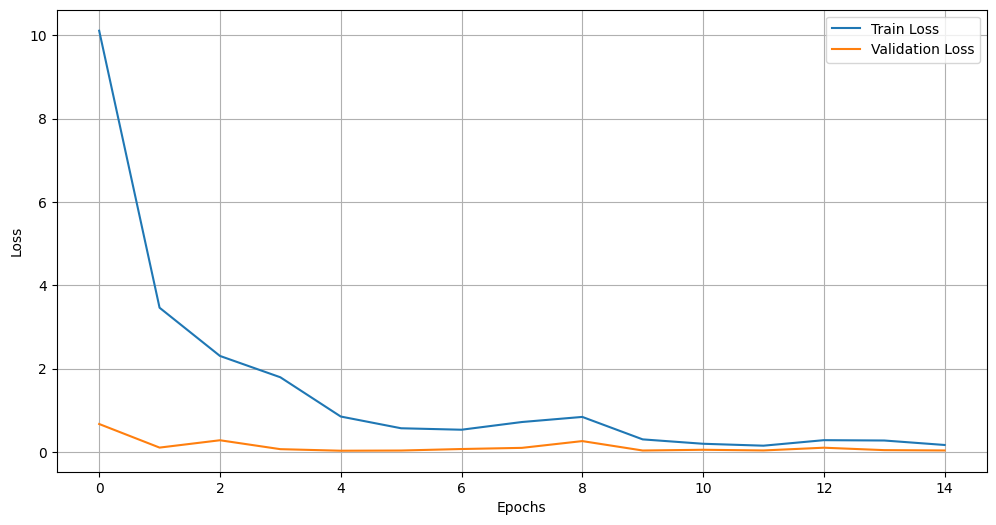

In [375]:
plt.figure(figsize=(12,6))
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

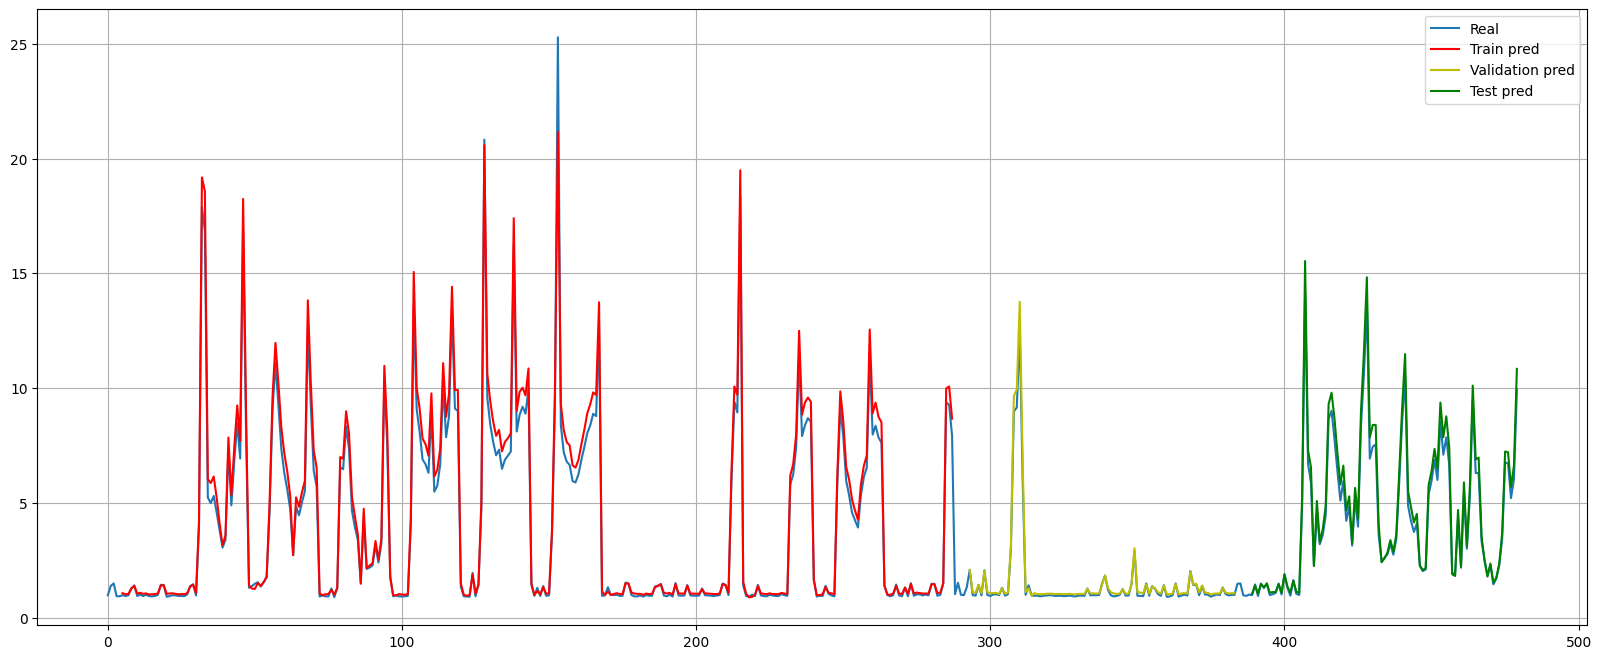

In [376]:
model.eval()
with torch.inference_mode():
    train_plot = (np.ones(shape=(timeseries.shape[0], 1)) * np.nan)[:,0]
    valid_plot = (np.ones_like(train_plot) * np.nan)
    test_plot = (np.ones_like(train_plot) * np.nan)
    train_plot[window:train_size] = model(X_train, y_train, True)[:, -1, -1]
    valid_plot[train_size+window:train_size+valid_size] = model(X_val, y_val, True)[:, -1, -1]
    test_plot[train_size+valid_size+window:len(timeseries)] = model(X_test, y_test, True)[:, -1, -1]
plt.figure(figsize=(20,8))
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(valid_plot, c='y')
plt.plot(test_plot, c='g')
plt.legend(['Real','Train pred', 'Validation pred', 'Test pred'])
plt.grid()
plt.show()